In [1]:
import cv2
import os
import numpy as np
import time

In [2]:
path = 'C:/Users/VE-ENG/Desktop/CMU_PIE_Face/Pose05_64x64_files/'
picPerPerson = 49

In [3]:
def load_testing(path,trainingRatio):
    picPerPerson = 49
    testingImagesPath = []
    testingIndices = []
    numPerson = len(os.listdir(path) )/picPerPerson
    traniningPicPerPerson = int(picPerPerson* trainingRatio)

    for personID in range(numPerson):
        for picID in range(traniningPicPerPerson,picPerPerson):
            fileName = path + str(personID) + '_' + str(picID) + '.jpg'
    #         img = cv2.imread(fileName,cv2.IMREAD_GRAYSCALE)
            testingImagesPath.append(fileName)
            testingIndices.append(personID)
    return testingImagesPath, testingIndices

In [4]:
def load_training(path, trainingRatio):
    picPerPerson = 49
    trainingImages = []
    trainingIndices = []
    traniningPicPerPerson = int(picPerPerson* trainingRatio)
    for personID in range(numPerson):
        for picID in range(traniningPicPerPerson):
            fileName = path + str(personID) + '_' + str(picID) + '.jpg'
            img = cv2.imread(fileName,cv2.IMREAD_GRAYSCALE)
            trainingImages.append(np.asarray(img, dtype = np.float32))
            trainingIndices.append(personID)
    return trainingImages, trainingIndices

In [5]:
# for KNN algorithm
def load_training_ML(path, trainingRatio):
    picPerPerson = 49
    trainingImages = []
    trainingIndices = []
    traniningPicPerPerson = int(picPerPerson* trainingRatio)

    for personID in range(numPerson):
        for picID in range(traniningPicPerPerson):
            fileName = path + str(personID) + '_' + str(picID) + '.jpg'
            img = cv2.imread(fileName,cv2.IMREAD_GRAYSCALE)
            trainingImages.append(np.asarray(img).flatten())
            trainingIndices.append(personID)
    return trainingImages, trainingIndices

In [6]:
def train_face_recognizer(trainingImages,trainingIndices, modelType = 0):
    tic = time.time()
    if modelType == 0:
        print 'LBPH Model training with %s images...' % len(trainingImages)
        recognizer = cv2.createLBPHFaceRecognizer()
    elif modelType == 1:
        print 'Eigen Face Model training with %s images...' % len(trainingImages)
        recognizer = cv2.createEigenFaceRecognizer()   
    elif modelType == 2:
        print 'Fisher Model training with %s images...' % len(trainingImages)
        recognizer = cv2.createFisherFaceRecognizer() 
    else:
        print "Invalid type of model selected, please check the modelType."
        return None
    recognizer.train(np.asarray(trainingImages, dtype=np.uint8), np.asarray(trainingIndices, dtype=np.int))

    toc = time.time()
#     print 'Model trained within %s sec.' % (toc - tic)
    return recognizer

In [7]:
def train_KNN(trainingImages, trainingIndices):
    tic = time.time()
    print 'KNN Model training with %s images...' % len(trainingImages)
    recognizer = cv2.KNearest()
    trainingData = np.mat(trainingImages, dtype=np.float32)
    recognizer.train(trainingData, np.asarray(trainingIndices))
    toc = time.time()
#     print 'Model trained within %s sec.' % (toc - tic)
    return recognizer

In [8]:
# for SVM algorithm
def train_SVM(trainingImages, trainingIndices):
    tic = time.time()
    print 'SVM Model training with %s images...' % len(trainingImages)
    recognizer = cv2.SVM()  
    params = dict( kernel_type = cv2.SVM_LINEAR,svm_type = cv2.SVM_C_SVC,  C = 1 )
    recognizer.train(np.asarray(trainingImages,dtype=np.float32), np.asarray(trainingIndices), params = params)
    toc = time.time()
#     print 'Model trained within %s sec.' % (toc - tic)
    return recognizer

In [9]:
# for KNN algorithm
def predict_KNN(recognizer,testingImagesPath, testingIndices, k = 3):
    inputImg = np.zeros((len(testingImagesPath),64*64),dtype=np.float32)
    count = 0
#     print 'Input %s images to predict result...' % len(testingImagesPath)
    tic = time.time()

    for index,fileName in enumerate(testingImagesPath):
        img = cv2.imread(fileName,cv2.IMREAD_GRAYSCALE)
        inputImg[index,:] = np.asarray(img, dtype=np.float32).flatten()

    ret, results, neighbours, dist = recognizer.find_nearest(inputImg, k)
    for predict, actual in zip(results,testingIndices):
        if predict == actual:
            count += 1

#     print 'Correct prediction count: %s' % count
    toc = time.time()
#     print 'Prediction done within %s sec.' % (toc - tic)
    accuracy = float(count)/len(testingIndices)
#     print 'Accuracy: %s' % (accuracy)
#     print 'Average time for one picture: %s' % ((toc - tic)/len(testingImagesPath))
    return accuracy, results

In [10]:
def predict_SVM(recognizer,testingImagesPath, testingIndices):
    tic = time.time()
    count = 0
    
    inputImg = np.zeros((len(testingImagesPath),64*64),dtype=np.float32)
    for index,fileName in enumerate(testingImagesPath):
        img = cv2.imread(fileName,cv2.IMREAD_GRAYSCALE)
        inputImg[index,:] = np.asarray(img, dtype=np.float32).flatten()
        
#     print 'Input %s images to predict result...' % len(testingImagesPath)
    results = np.float32( [recognizer.predict(s) for s in inputImg] )
    for predict, actual in zip(results,testingIndices):
        if predict == actual:
            count += 1
#     print 'Correct prediction count: %s' % count
    toc = time.time()
#     print 'Prediction done within %s sec.' % (toc - tic)
    accuracy = float(count)/len(testingIndices)
#     print 'Accuracy: %s' % (accuracy)
#     print 'Average time for one picture: %s' % ((toc - tic)/len(testingImagesPath))
    return accuracy, results

In [11]:
def predict_face_recognizer(recognizer,testingImagesPath, testingIndices):
    predictionList = []
    confidenceList = []
    count = 0
#     print 'Input %s images to predict result...' % len(testingImagesPath)
    tic = time.time()
    for index,fileName in enumerate(testingImagesPath):
        img = cv2.imread(fileName,cv2.IMREAD_GRAYSCALE)
        prediction, confidence = recognizer.predict(img)
    #     print '%s prediction done.' % fileName
        predictionList.append(int(prediction))
        confidenceList.append(confidence)  
        if prediction == testingIndices[index]:
            count +=1
#     print 'Correct prediction count: %s' % count
    toc = time.time()
#     print 'Prediction done within %s sec.' % (toc - tic)
    accuracy = float(count)/len(testingIndices)
#     print 'Accuracy: %s' % (accuracy)
#     print 'Average time for one picture: %s' % ((toc - tic)/len(testingImagesPath))
    return accuracy, predictionList, confidenceList


In [12]:
accuracy_KNN_list = []
accuracy_SVM_list = []
accuracy_LBPH_list = []
accuracy_eigen_list = []
accuracy_fisher_list = []

time_KNN_list = []
time_SVM_list = []
time_LBPH_list = []
time_eigen_list = []
time_fisher_list = []

for trainingRatio in [x/10.0 for x in range(1,10)]:

    numPerson = len(os.listdir(path) )/picPerPerson
    traniningPicPerPerson = int(picPerPerson* trainingRatio)
    print 'training:testing = %s:%s' % (int(100*trainingRatio), int(100 - 100*trainingRatio))
    print 'training pic per person: %s\n' %(traniningPicPerPerson)

    testingImagesPath, testingIndices = load_testing(path,trainingRatio)
    trainingImages_ML, trainingIndices = load_training_ML(path, trainingRatio)
    trainingImages, trainingIndices = load_training(path, trainingRatio)

    tic = time.time()
    recognizer = train_KNN(trainingImages_ML,trainingIndices)
    accuracy_KNN, results_KNN = predict_KNN(recognizer,testingImagesPath,testingIndices, k =4)
    accuracy_KNN_list.append(accuracy_KNN)
    time_KNN_list.append(time.time()-tic)  
    print '------------------------------------'
    tic = time.time()
    recognizer = train_SVM(trainingImages_ML,trainingIndices)
    accuracy_SVM, results_SVM = predict_SVM(recognizer,testingImagesPath,testingIndices)
    accuracy_SVM_list.append(accuracy_SVM)
    time_SVM_list.append(time.time()-tic)
    print '------------------------------------'
    tic = time.time()
    recognizer = train_face_recognizer(trainingImages,trainingIndices)
    accuracy_LBPH, results_LBPH, confidence = predict_face_recognizer(recognizer,testingImagesPath,testingIndices)
    accuracy_LBPH_list.append(accuracy_LBPH)
    time_LBPH_list.append(time.time()-tic)
#     print '------------------------------------'
#     tic = time.time()
#     recognizer = train_face_recognizer(trainingImages,trainingIndices,1)
#     accuracy_eigen, results_eigen, confidence = predict_face_recognizer(recognizer,testingImagesPath,testingIndices)
#     accuracy_eigen_list.append(accuracy_LBPH)
#     time_eigen_list.append(time.time()-tic)
#     print '------------------------------------'
#     tic = time.time()
#     recognizer = train_face_recognizer(trainingImages,trainingIndices,2)
#     accuracy_fisher, results_fisher, confidence = predict_face_recognizer(recognizer,testingImagesPath,testingIndices)
#     accuracy_fisher_list.append(accuracy_LBPH)
#     time_fisher_list.append(time.time()-tic)
    print '------------------------------------\n'
print 'Done.'

training:testing = 10:90
training pic per person: 4

KNN Model training with 272 images...
------------------------------------
SVM Model training with 272 images...
------------------------------------
LBPH Model training with 272 images...
------------------------------------

training:testing = 20:80
training pic per person: 9

KNN Model training with 612 images...
------------------------------------
SVM Model training with 612 images...
------------------------------------
LBPH Model training with 612 images...
------------------------------------

training:testing = 30:70
training pic per person: 14

KNN Model training with 952 images...
------------------------------------
SVM Model training with 952 images...
------------------------------------
LBPH Model training with 952 images...
------------------------------------

training:testing = 40:60
training pic per person: 19

KNN Model training with 1292 images...
------------------------------------
SVM Model training with 1292 

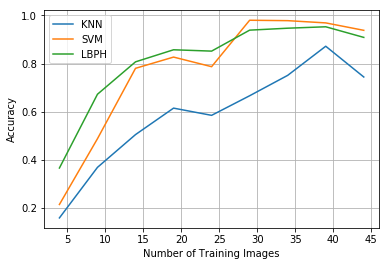

In [13]:
import matplotlib.pyplot as plt

numTrainImages =  [picPerPerson*x/10 for x in range(1,10)]
plt.plot(numTrainImages, accuracy_KNN_list, label = 'KNN')
plt.plot(numTrainImages, accuracy_SVM_list, label = 'SVM')
plt.plot(numTrainImages, accuracy_LBPH_list, label = 'LBPH')
# plt.plot(numTrainImages, accuracy_eigen_list, label = 'Eigen Face')
# plt.plot(numTrainImages, accuracy_fisher_list, label = 'Fisher')
plt.xlabel('Number of Training Images')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

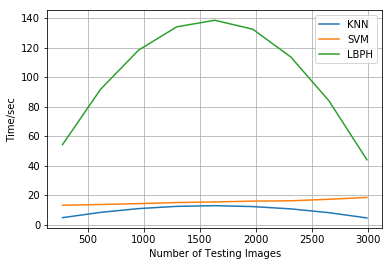

In [26]:
numTestImages =[(picPerPerson*x/10)*68 for x in range(9,0,-1)]

plt.plot(numTestImages, time_KNN_list, label = 'KNN')
plt.plot(numTestImages, time_SVM_list, label = 'SVM')
plt.plot(numTestImages, time_LBPH_list, label = 'LBPH')

plt.xlabel('Number of Testing Images')
plt.ylabel('Time/sec')
plt.legend()
plt.grid()
plt.show()